In [2]:
from pathlib import Path
import os

creds = '{"username":"sebasmanco","key":"a0f01aadb0e584b9c9aa0e8ebf5a2696"}'                        # credentials for kaggle APi 

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

# using a framework

In [3]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format

## prep the data:

In [20]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C


In [21]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))
  

add_features(df)

In [22]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,True,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S,2.64,NaN,0,True,1,NaN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S,3.43,ABC,0,True,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,3.20,NaN,3,False,2,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C,3.43,ABC,0,True,1,Mr


In [23]:
splits = RandomSplitter(seed=42)(df)

In [24]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

## train the model

In [25]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0691830962896347, valley=0.010964781977236271)

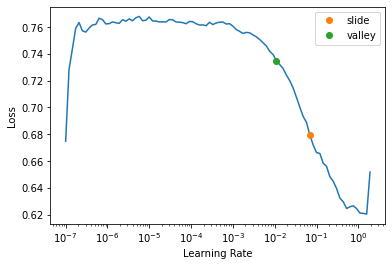

In [26]:
learn.lr_find(suggest_funcs=(slide, valley))

In [28]:
learn.fit(16, lr=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.371922,0.422324,0.820225,00:00
1,0.363328,0.424704,0.825843,00:00
2,0.361017,0.412320,0.825843,00:00
3,0.358420,0.414253,0.837079,00:00
4,0.356668,0.429550,0.831461,00:00
5,0.353251,0.416861,0.831461,00:00
6,0.353990,0.430788,0.837079,00:00
7,0.354099,0.431265,0.848315,00:00
8,0.356574,0.420397,0.825843,00:00
9,0.354665,0.426213,0.831461,00:00


In [32]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [33]:
tst_dl = learn.dls.test_dl(tst_df)
preds,_ = learn.get_preds(dl=tst_dl)

## ensembling

In [29]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [34]:
learns = [ensemble() for _ in range(5)]

In [38]:
ens_preds = torch.stack(learns).mean(0)
ens_preds

tensor([[0.8778, 0.1222],
        [0.5518, 0.4482],
        [0.9473, 0.0527],
        [0.8826, 0.1174],
        [0.3453, 0.6547],
        [0.8885, 0.1115],
        [0.4561, 0.5439],
        [0.9356, 0.0644],
        [0.2400, 0.7600],
        [0.9211, 0.0789],
        [0.9274, 0.0726],
        [0.8891, 0.1109],
        [0.0239, 0.9761],
        [0.9625, 0.0375],
        [0.0242, 0.9758],
        [0.0351, 0.9649],
        [0.9020, 0.0980],
        [0.8256, 0.1744],
        [0.5823, 0.4177],
        [0.5218, 0.4782],
        [0.9088, 0.0912],
        [0.0735, 0.9265],
        [0.0704, 0.9296],
        [0.8490, 0.1510],
        [0.0947, 0.9053],
        [0.9522, 0.0478],
        [0.0587, 0.9413],
        [0.8288, 0.1712],
        [0.7713, 0.2287],
        [0.9220, 0.0780],
        [0.9468, 0.0532],
        [0.9348, 0.0652],
        [0.4098, 0.5902],
        [0.3134, 0.6866],
        [0.6266, 0.3734],
        [0.8252, 0.1748],
        [0.5846, 0.4154],
        [0.5614, 0.4386],
        [0.8

In [36]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

In [39]:
!head ens_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
